# Projection of political actors onto populism subdimensions

In [182]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

In [183]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
# import multiprocessing
# available_workers = multiprocessing.cpu_count()
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

## Data

In [216]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs_2015_low.p'

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP', 'M', 'DD', 'UFG', 'KD']")
parl_data.shape

(156448, 6)

In [217]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])


In [218]:
# Load embedding
model_path = 'embedding_models/fastlearn_2015_low.txt'
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [219]:
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'Konservative',
   6: 'SF',
   7: 'Liberal_Alliance',
   #8: 'UFG',
   8: 'Alternativet',
   #9: 'Danmarksdemokraterne',
   9: 'Nye Borgerlige',
   10: 'Frie Grønne',
   #13: 'Moderaterne',
   #14: 'Kristendemokraterne'
}

In [220]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    #'KD': '#566197',
    'FG': '#E4F04E',
    #'DD': '#3470BC',
    #'M': '#7A308B',
    #'SIU': 'lightgrey',
    #'UFG': 'lightgrey'
}

In [221]:
grouped_docs['party'].value_counts()

S      55
V      47
DF     37
EL     18
SF     16
RV     15
KF     15
LA     13
ALT    11
NB      4
FG      3
Name: party, dtype: int64

In [222]:
#map party_labels keys to party_df
party_df = grouped_docs['party'].map(party_labels)

In [223]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())
party_df.loc[party_df['party'] == 'KF', 'rank'] = 16 # necessary due to slight inconsistency in the order in which parties are output...

party_labels = party_df.drop_duplicates(keep = 'first', subset = 'party').sort_values(by='rank', ascending=False)

partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

party_labels

party sizes before filtering (party 19 is "Other"):

[[ 0 54]
 [ 1 47]
 [ 2 37]
 [ 3 18]
 [ 4 16]
 [ 5 16]
 [ 6 15]
 [ 7 13]
 [ 8 11]
 [ 9  4]
 [10  3]]


,doc,party,snippet,color,full_name,rank
2,2,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,55
6,6,V,tak for ordet nu har vi jo talt rigtig meget o...,#1A4289,Anne Honoré Østergaard,47
0,0,DF,tak for det jeg er lidt forvirret på et højere...,#265BA4,Alex Ahrendtsen,37
32,32,EL,tak for det jeg vil gerne spørge ordføreren om...,#BF2850,Christian Juhl,18
9,9,SF,tak for det vi er flere her der har svære navn...,#B42D27,Anne Valentina Berthelsen,16
17,17,KF,tak for det tak for en fin ordførertale det da...,#24573E,Birgitte Bergman,16
4,4,RV,tak for en rigtig god tale det var også godt d...,#D82E8A,Andreas Steenberg,15
1,1,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13
28,28,ALT,tak for det nu sagde ordføreren i sin ordfører...,#75FB4C,Carolina Magdalene Maier,11
113,113,NB,jeg skal prøve at inddrage hr søren pape pouls...,#1E4B57,Lars Boje Mathiesen,4


In [224]:
party_df['party'].value_counts()
# NOTE: The inconsistency in number/rank is caused by semantic outliers
# that the the model would have put into another party than their own!
# TODO: Check that we still compute party based on a priori party affil
# and maybe fix the output print of get_doc_party_df if it is misleading...
#
# I mean, wasn't this the entire reason that we needed to overwrite labels in the first place?
# As of xxxx, it was decided and so forth?

S      55
V      47
DF     37
EL     18
SF     16
RV     15
KF     15
LA     13
ALT    11
NB      4
FG      3
Name: party, dtype: int64

In [225]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

## Construction of scales

In [226]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [1117]:
from itertools import combinations
from tqdm.notebook import tqdm

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        return Politician2Vec._l2_normalize(mean_vec(self.vecs['present'])), Politician2Vec._l2_normalize(mean_vec(self.vecs['absent']))
        #return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent']) # TODO: Figure out whether or not to normalise!
    
    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [4349]:
PC_present_words = [
    'flere folkeafstemninger',
    # 'direkte demokrati',
    'christiansborg diktere',
    #'usandt folektinget',
    #'utopi',
    #'voldsom centralisering',
    'løftebrud',
    'politiske elite',
    'danskerne bestemmer',
    #'danske folk',
    'danske folks',
    'almindelige danskere',
    #'almindelig dansker',
    #'almindelig borger',
    #'ved bedst'
    ]

PC_absent_words = [
    'repræsentativt demokrati',
    'parlamentarisk demokrati',
    #'lytte eksperter',
    'politisk beslutning',
    'politisk opgave',
    #'flere eksperter',
    #'forskellige eksperter',
    'politisk ansvar',
    #'folkevalgte',
    #'parlamentarisk',
    'stærkt mandat'
    ]

AP_present_words = [
    'danske værdier',
    'folkets vilje',
    # 'hele folkets',
    # 'folkets stemme',
    'danskerne ønsker',
    'uforeneligt dansker',
    'vores modersmål',
    # 'fællesskabets interesser',
    #'grænsekontrol',
    'stram udlændingepolitik',
    # 'fratages statsborgerskab',
    # 'illegale migranter',
    # 'islamisering',
    # 'kulturelle fællesskab',
    # 'store integrationsproblemer',
    'parallelsamfund',
    # 'økonomiske migranter',
    # 'ufravigelige krav',
    # 'kriminelle udlændinge',
    # 'kultur tradition'
    ]

AP_absent_words = [
    'racisme diskrimination',
    'mangfoldigt samfund',
    'statsborgerskab rettighed',
    # 'ret selvbestemmelse',
    # 'forskellige prioriteter',
    'frihed vælge',
    # 'ligestilling mangfoldighed',
    'tolerance',
    'hensyn minoriteter',
    'tværs etniske',
    #'ønsker imødekomme',
    # 'gerne imødekomme',
    'plads forskellighed',
    'skader integrationen',
    #'forskellighed',
    # 'trods uenigheder',
    # 'åben diskussion',
    # 'bred diskussion',
    # 'fordomsfri diskussion',
    # 'god diskussion',
    # 'legitim diskussion',
    # 'godt kompromis',
    # 'fint kompromis',
    # 'fornuftigt kompromis',
    # 'kompromisets kunst',
    # 'kompromis',
    # 'hjælpe flygtninge',
    ]

MP_present_words = [
    'eneste rigtige',
    # 'bruge magt',
    'snyder vægten',
    'normer værdier',
    'bilde danskerne',
    'ufravigelige krav',
    # 'kvindeundertrykkende',
    'nedladende',
    'glidebane',
    # 'moralsk forkert',
    'moralsk forkasteligt',
    'hamrende uretfærdigt',
    'bag lyset',
    # 'løgn',
    #'lyver folketinget',
    #'uærlig',
    # 'tale usandt',
    # 'trussel vores',
    #'moral',
    #'værdier normer',
    #'værdier moral',
    # 'værdier strider',
    # 'gode onde',
    # 'uansvarlig',
    # 'synes skammeligt',
    'burde skamme',
    'dybt forarget',
    #'fuldstændig utilstedeligt',
    'helt utilstedeligt',
    'undergraver danske',
    #'synes utilstedeligt',
    # 'dybt uretfærdigt',
    #'synes uretfærdigt',
    #'hamrende uretfærdigt',
    #'mest retfærdige',
    ]

MP_absent_words = [
    # 'faglige saglige',
    # 'klogt fornuftigt',
    # 'gerne rose',
    'grundlæggende enige',
    'kan diskuteres',
    # 'faglige vurdering',
    # 'rent teknisk',
    # 'teknisk diskussion',
    # 'beregninger viser',
    # 'neutral',
    # 'embedsfolk',
    'takke kvittere',
    #'konstruktivt samarbejde',
    # 'forskellige fortolkninger',
    # 'sætter pris',
    'tværs partiskel',
    'gerne imødekomme',
    # 'trods uenigheder',
    # 'gøre dommer',
    'tage forbehold',
    # 'objektive krav',
    # 'objektivt set'
    ]

PC_dimension = Subdimension(
    present_words=PC_present_words,
    absent_words=PC_absent_words
    )

AP_dimension = Subdimension(
    present_words=AP_present_words,
    absent_words=AP_absent_words
    )

MP_dimension = Subdimension(
    present_words=MP_present_words,
    absent_words=MP_absent_words
    )

In [4350]:
pol2vec_model.model.wv.most_similar(positive=['socialdemokratiet', 'flertal'], topn=25)

[('partier', 0.6987056136131287),
 ('folketinget', 0.6840076446533203),
 ('venstre', 0.6527209877967834),
 ('folkeparti', 0.6372002363204956),
 ('socialdemokratiets', 0.6354696750640869),
 ('regeringen', 0.6310381293296814),
 ('forslag', 0.6309755444526672),
 ('bredt', 0.6264134645462036),
 ('dag', 0.6132868528366089),
 ('enige', 0.6120160222053528),
 ('stemmer', 0.6114698052406311),
 ('derfor', 0.6092608571052551),
 ('regering', 0.6051797866821289),
 ('ønsker', 0.6049073934555054),
 ('gerne', 0.6026461124420166),
 ('socialdemokraterne', 0.5952990651130676),
 ('tidligere', 0.5817875862121582),
 ('stemme', 0.5806131958961487),
 ('står', 0.5791081786155701),
 ('set', 0.5789790153503418),
 ('radikale', 0.5776296854019165),
 ('politik', 0.5747585296630859),
 ('fremsat', 0.5726593136787415),
 ('før', 0.5711671710014343),
 ('tak', 0.571025550365448)]

In [4351]:
print(PC_dimension.words)
print(len(PC_dimension.vecs['present']))

{'present': ['flere folkeafstemninger', 'vælgerne afgør', 'christiansborg diktere', 'løftebrud', 'politiske elite', 'danskerne bestemmer', 'danske folks', 'almindelige danskere'], 'absent': ['repræsentativt demokrati', 'parlamentarisk demokrati', 'politisk beslutning', 'politisk opgave', 'politisk ansvar', 'stærkt mandat']}
8


In [4352]:
best_vecs, best_words = PC_dimension.optimise_subdim(present=True, min_size=6, max_size=7, replace=True)
print(best_words)

best_vecs, best_words = PC_dimension.optimise_subdim(present=False, min_size=6, max_size=7, replace=True)
print(best_words)

  0%|          | 0/2 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.586
['flere folkeafstemninger', 'vælgerne afgør', 'christiansborg diktere', 'politiske elite', 'danskerne bestemmer', 'danske folks']


  0%|          | 0/2 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.687
['repræsentativt demokrati', 'parlamentarisk demokrati', 'politisk beslutning', 'politisk opgave', 'politisk ansvar', 'stærkt mandat']


In [4353]:
# Present:
for subdimension in [AP_dimension, MP_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=True, min_size=6, max_size=8, replace=True)
    print(best_words)

# Absent:
for subdimension in [AP_dimension, AP_dimension]:
    best_vecs, best_words = subdimension.optimise_subdim(present=False, min_size=6, max_size=8, replace=True)
    print(best_words)

  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.619
['danske værdier', 'folkets vilje', 'danskerne ønsker', 'uforeneligt dansker', 'vores modersmål', 'stram udlændingepolitik']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.624
['eneste rigtige', 'ufravigelige krav', 'moralsk forkasteligt', 'burde skamme', 'dybt forarget', 'undergraver danske']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.644
['racisme diskrimination', 'mangfoldigt samfund', 'frihed vælge', 'hensyn minoriteter', 'tværs etniske', 'plads forskellighed']


  0%|          | 0/3 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.644
['racisme diskrimination', 'mangfoldigt samfund', 'frihed vælge', 'hensyn minoriteter', 'tværs etniske', 'plads forskellighed']


In [4354]:
PC_present, PC_absent = PC_dimension.calc_subdim_vecs()
AP_present, AP_absent = AP_dimension.calc_subdim_vecs()
MP_present, MP_absent = MP_dimension.calc_subdim_vecs()

PC_axis = PC_present - PC_absent
AP_axis = AP_present - AP_absent
MP_axis = MP_present - MP_absent

## Plotting and validation

In [4355]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.patheffects as pe
plt.rcParams['figure.dpi'] = 250

# define a funciton that takes a column from df_val and plots it as as sorted bar chart
def plot_bar(df, col, title, xlabel, ylabel, color):
    df = df.sort_values(col, ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Partyabb'], rescale(df[col]), color=df[color])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# define a funciton to plot the same data as a 1-dimensional dot plot
def plot_dot(df, col, title, xlabel, color, jitter=False):
    plt.figure(figsize=(15, 2.5))
    if jitter:
        y_jitter = np.random.normal(scale=0.001, size=len(df[col]))
        plt.scatter(rescale(df[col]), y_jitter, color='white')
    else:
        plt.scatter(rescale(df[col]), np.zeros_like(rescale(df[col])), color=df[color])

    # add party labels
    for i, txt in enumerate(df['Partyabb']):
            plt.text(rescale(df[col])[i], y_jitter[i], txt, ha='center', va='center', fontsize=20, color=df[color][i], weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    plt.grid(False)
    plt.box(False)
    plt.yticks([])
    
    plt.axhline(y=0, color='darkgrey', linewidth=1)
    plt.axvline(x=0, color='darkgrey', linewidth=1, linestyle=':')

    plt.ylim(-0.005, 0.005)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# define a function that takes a variable and rescales it to the range -1 to 1
def rescale(var):
    var = (var - var.min()) / (var.max() - var.min())
    var = 2 * var - 1
    return var

In [4356]:
df_val = pd.read_excel('data/validation_poppa.xlsx')[['Partyabb', 'peoplecentrism', 'indivisble', 'manichean', 'populism']]

In [4357]:
df_test = party_labels[['party', 'color', 'rank']]

In [4358]:
df_plot = df_test.merge(df_val, left_on='party', right_on='Partyabb', how='left').sort_values('rank', ascending=False)

In [4359]:
PC_comp = 'peoplecentrism'
AP_comp = 'indivisble'
MP_comp = 'manichean'

In [4360]:
df_plot

,party,color,rank,Partyabb,peoplecentrism,indivisble,manichean,populism
0,S,#C8042C,55,S,4.200000,5.000000,5.222222,3.993267
1,V,#1A4289,47,V,4.500000,5.000000,5.222222,3.867266
2,DF,#265BA4,37,DF,7.800000,7.666666,7.600000,7.955809
3,EL,#BF2850,18,EL,5.000000,3.777778,7.375000,4.797755
4,SF,#B42D27,16,SF,3.400000,2.875000,5.888889,3.143496
5,KF,#24573E,16,KF,4.200000,4.555555,5.600000,3.874101
6,RV,#D82E8A,15,RV,2.200000,2.333333,5.500000,1.473822
7,LA,#E7B657,13,LA,4.500000,3.000000,6.333334,2.745015
8,ALT,#75FB4C,11,ALT,3.666667,2.000000,6.444445,2.707714
9,NB,#1E4B57,4,NB,7.857143,7.833334,8.000000,8.138557


In [4361]:
# assume we have a matrix of word and document vectors called `embedding_matrix`
# with shape (num_documents, embedding_dimension)
embedding_matrix = pol2vec_model.party_vectors

# assume we have three subdimension vectors called `v1`, `v2`, and `v3`
# with shape (embedding_dimension,)

# create a matrix called `projection_matrix` with shape (embedding_dimension, 3)
# that has the three subdimension vectors as columns
projection_matrix = np.stack((PC_axis, AP_axis, MP_axis), axis=1)

# project the document vectors onto the subspace described by the three
# subdimension vectors by multiplying the embedding matrix by the projection
# matrix 
# the resulting matrix will have shape (num_documents, 3)
projected_matrix = embedding_matrix.dot(projection_matrix)

# The resulting projected_matrix will be a matrix with shape (num_documents, 3)
# that represents the document vectors projected onto the subspace described by
# the three "special" vectors. Each row of the matrix corresponds to a document,
# and the three columns correspond to the three sub-dimensions of populism

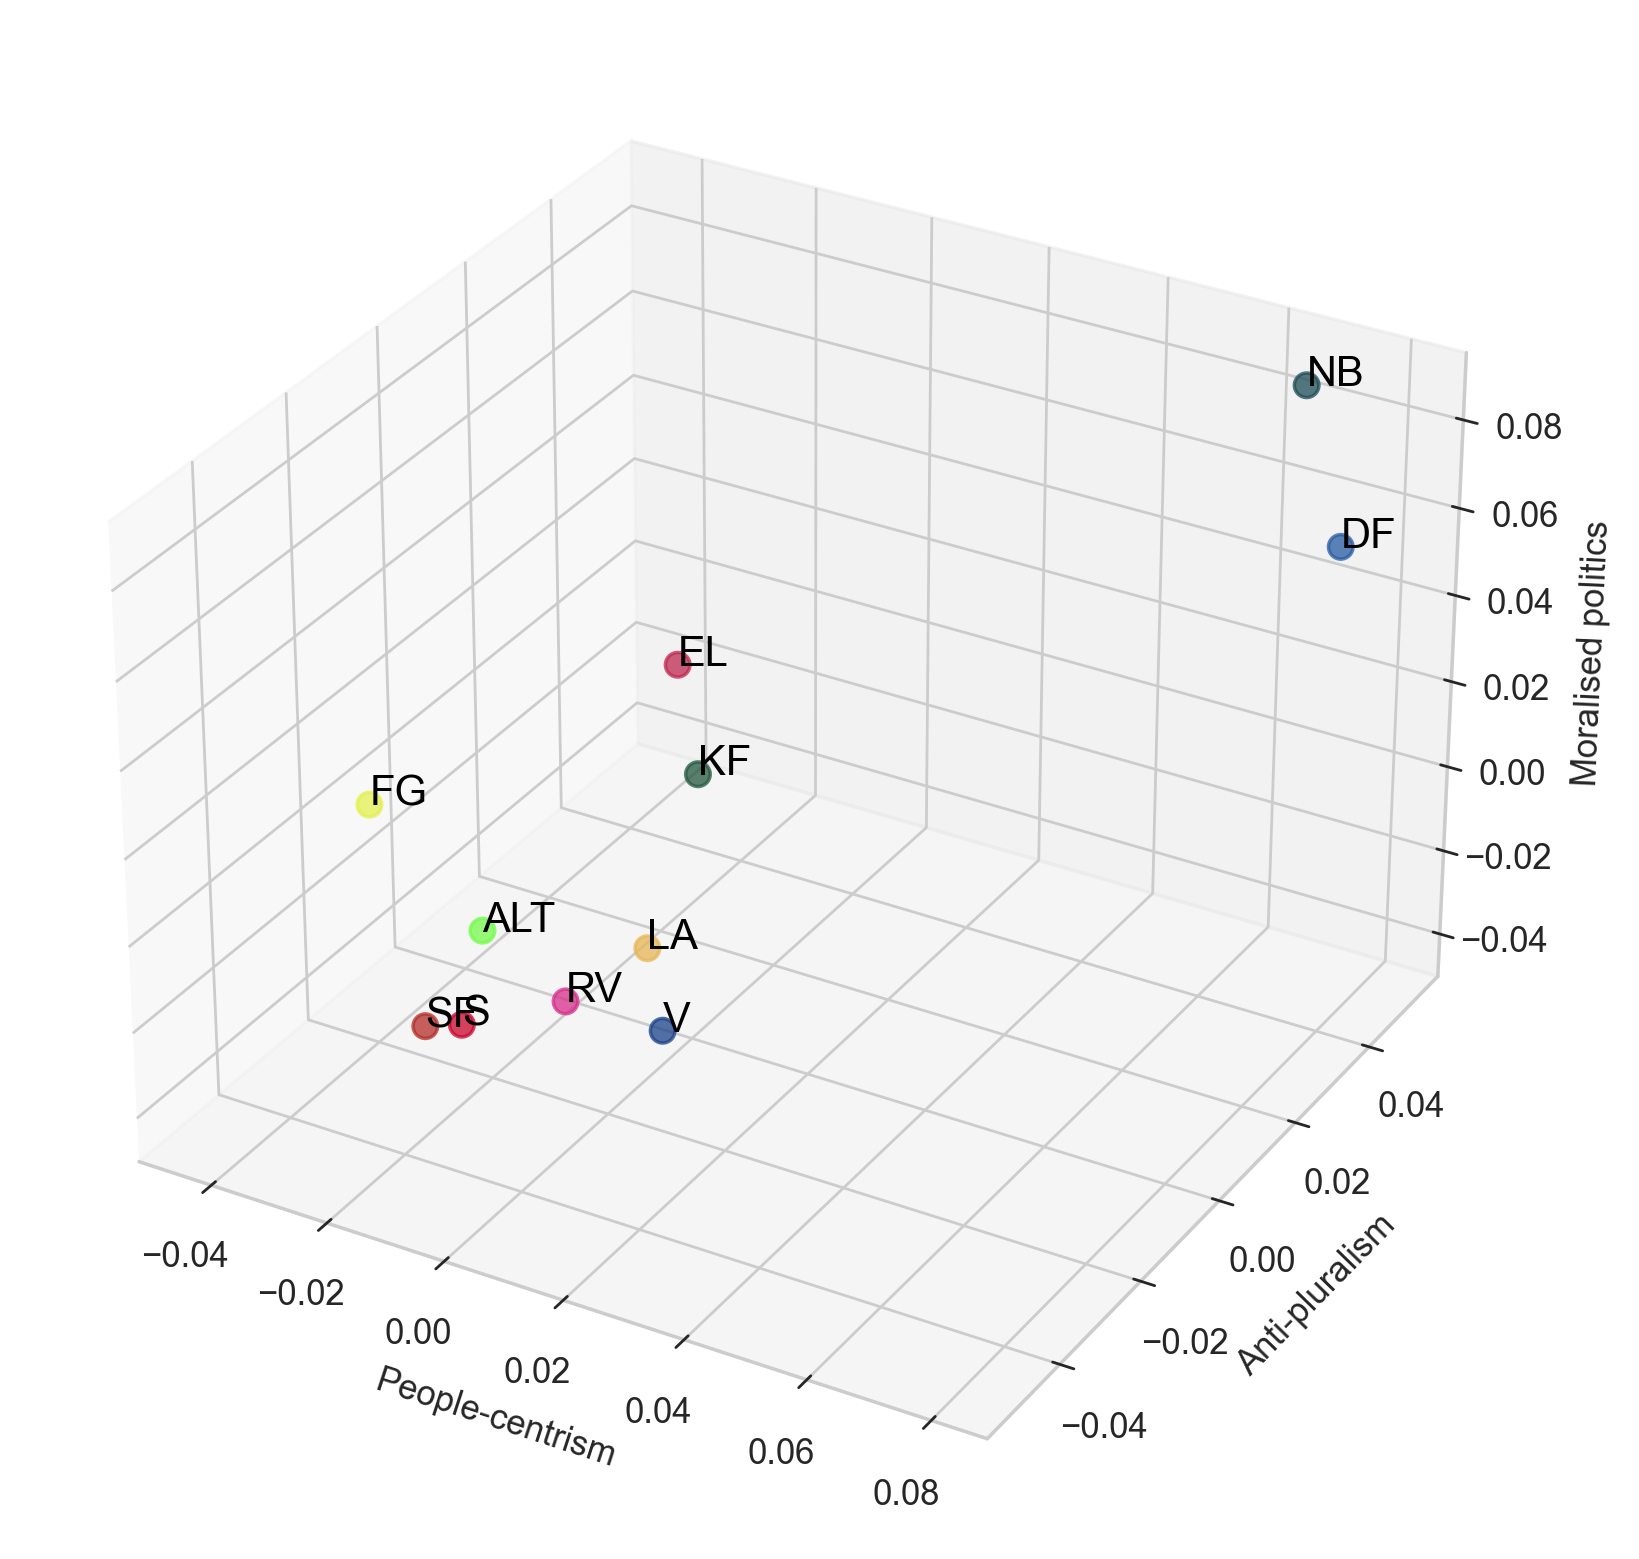

In [4362]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

# Initialize the plot and set the axis labels
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('People-centrism')
ax.set_ylabel('Anti-pluralism')
ax.set_zlabel('Moralised politics')

# Set the range of the axis
# ax.set_xlim([0.02, 0.125])
# ax.set_ylim([-0.01, 0.2])
# ax.set_zlim([0, 0.075])

# Create a scatter plot of the politician embeddings
xs = embeddings[:,0]
ys = embeddings[:,1]
zs = embeddings[:,2]
ax.scatter(xs, ys, zs, s=50, alpha=0.75, color=party_labels['color'])

for i, embedding in enumerate(embeddings):
    x, y, z = embedding
    ax.text(x, y, z, party_labels.iloc[i]['party'], color='black', size=12)

# Add selected word vectors and labels to the plot
# def plot_words(ax, dimension, projection_matrix, color, size=7):

#     for i, dimvec in enumerate(dimension.vecs['present']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['present'][i], color=color, size=size)

#     for i, dimvec in enumerate(dimension.vecs['absent']):
#         x, y, z = projection_matrix.T.dot(dimvec)
#         ax.scatter(x, y, z, s=0.25, alpha=1, color=color)
#         ax.text(x, y, z, dimension.words['absent'][i], color=color, size=size)

# plot_words(ax, PC_dimension, projection_matrix, 'red')
# plot_words(ax, AP_dimension, projection_matrix, 'blue')
# plot_words(ax, MP_dimension, projection_matrix, 'green')

# Show the plot
plt.show()

In [4363]:
# Assume you have a matrix of politician embeddings in the populism subspace,
# where each row represents an embedding and each column represents a subdimension.
embeddings = projected_matrix

normalised_emb = 2*(embeddings - np.min(embeddings, axis=0)) / np.ptp(embeddings, axis=0) - 1

In [4364]:
# map dimensions of normalised_emb to df_plot
df_plot['PC'] = normalised_emb[:, 0]
df_plot['AP'] = normalised_emb[:, 1]
df_plot['MP'] = normalised_emb[:, 2]

In [4365]:
df_plot = df_plot.dropna()

In [4366]:
# rescale PG_left_right and PG_liberty_authority to the range -1 to 1
df_plot[PC_comp] = rescale(df_plot[PC_comp])
df_plot[AP_comp] = rescale(df_plot[AP_comp])
df_plot[MP_comp] = rescale(df_plot[MP_comp])

df_plot['PC'] = rescale(df_plot['PC'])
df_plot['AP'] = rescale(df_plot['AP'])
df_plot['MP'] = rescale(df_plot['MP'])

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [4367]:
df_plot

,party,color,rank,Partyabb,peoplecentrism,indivisble,manichean,populism,PC,AP,MP
0,S,#C8042C,55,S,-0.292929,0.028571,-1.000,3.993267,-1.000000,-0.464195,-0.928396
1,V,#1A4289,47,V,-0.186869,0.028571,-1.000,3.867266,-0.537501,-0.173471,-1.000000
2,DF,#265BA4,37,DF,0.979798,0.942857,0.712,7.955809,1.000000,0.809321,0.611964
3,EL,#BF2850,18,EL,-0.010101,-0.390476,0.550,4.797755,-0.350500,-0.348244,0.517262
4,SF,#B42D27,16,SF,-0.575758,-0.700000,-0.520,3.143496,-0.706320,-1.000000,-0.447563
5,KF,#24573E,16,KF,-0.292929,-0.123810,-0.728,3.874101,-0.552128,0.021286,-0.184846
6,RV,#D82E8A,15,RV,-1.000000,-0.885714,-0.800,1.473822,-0.700951,-0.393283,-0.788955
7,LA,#E7B657,13,LA,-0.186869,-0.657143,-0.200,2.745015,-0.271407,-0.605602,-0.296567
8,ALT,#75FB4C,11,ALT,-0.481481,-1.000000,-0.120,2.707714,-0.633013,-0.841643,-0.189712
9,NB,#1E4B57,4,NB,1.000000,1.000000,1.000,8.138557,0.764086,1.000000,1.000000


In [4368]:
from scipy.stats import pearsonr
print('PC correlation:', pearsonr(df_plot['PC'], df_plot[PC_comp]))
print('AC correlation:', pearsonr(df_plot['AP'], df_plot[AP_comp]))
print('MP correlation:', pearsonr(df_plot['MP'], df_plot[MP_comp]))


PC correlation: (0.9177517985489356, 0.00018111807251381269)
AC correlation: (0.9207298701144686, 0.00015685329387716496)
MP correlation: (0.9678583337380291, 4.491604151376423e-06)


In [4422]:
def jitter(var): return np.random.normal(scale=0.005, size=len(var))

y_jitter = jitter(df_plot[test_metric])

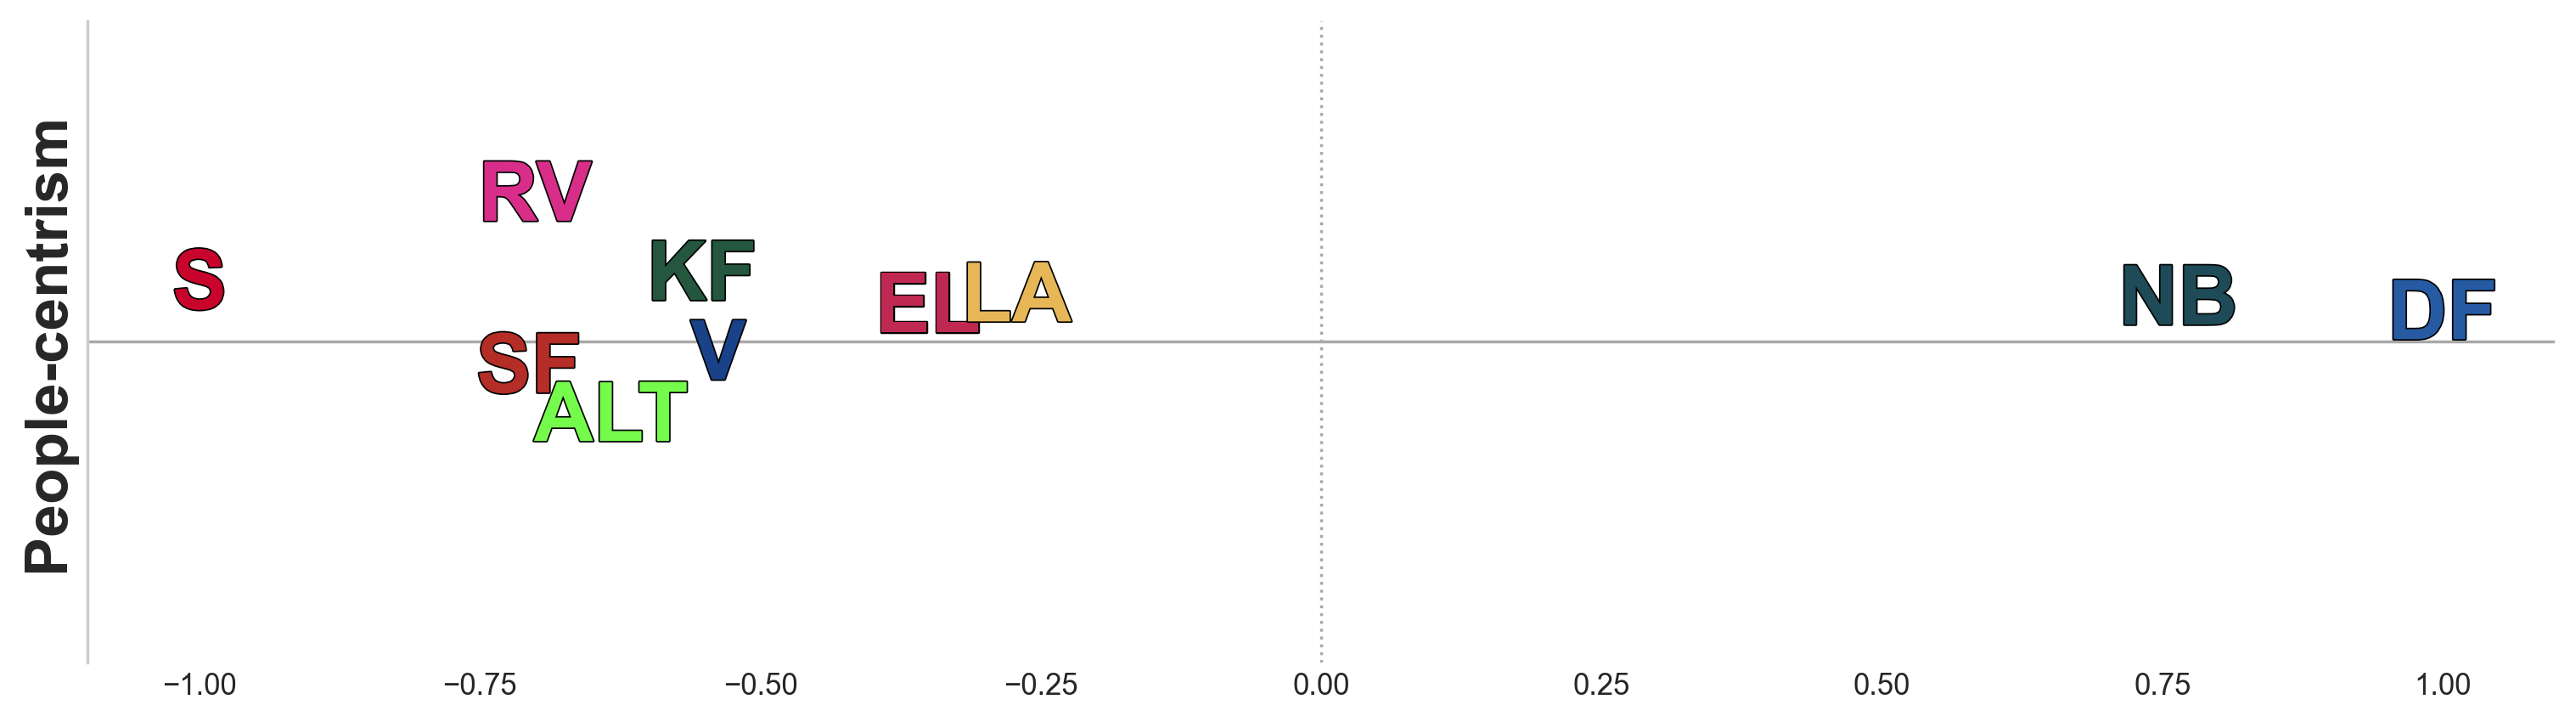

People-centrism correlation: (0.9177517985489356, 0.00018111807251381269)


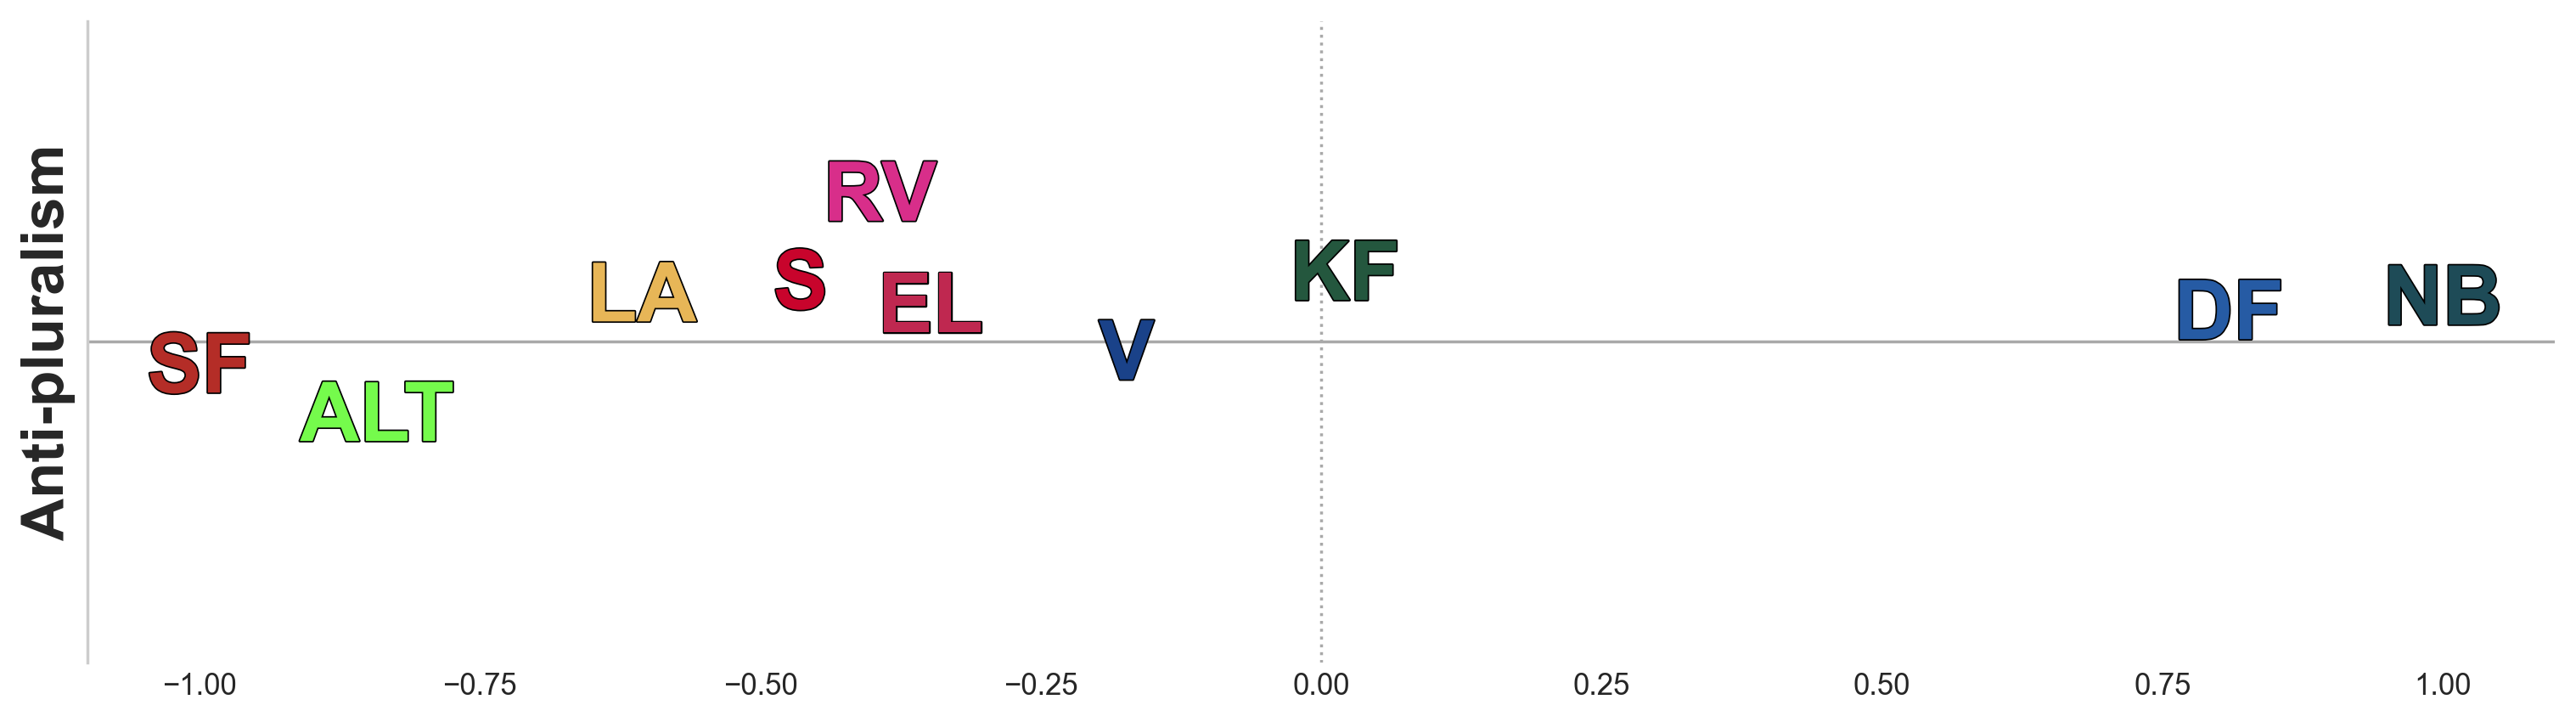

Anti-pluralism correlation: (0.9207298701144686, 0.00015685329387716496)


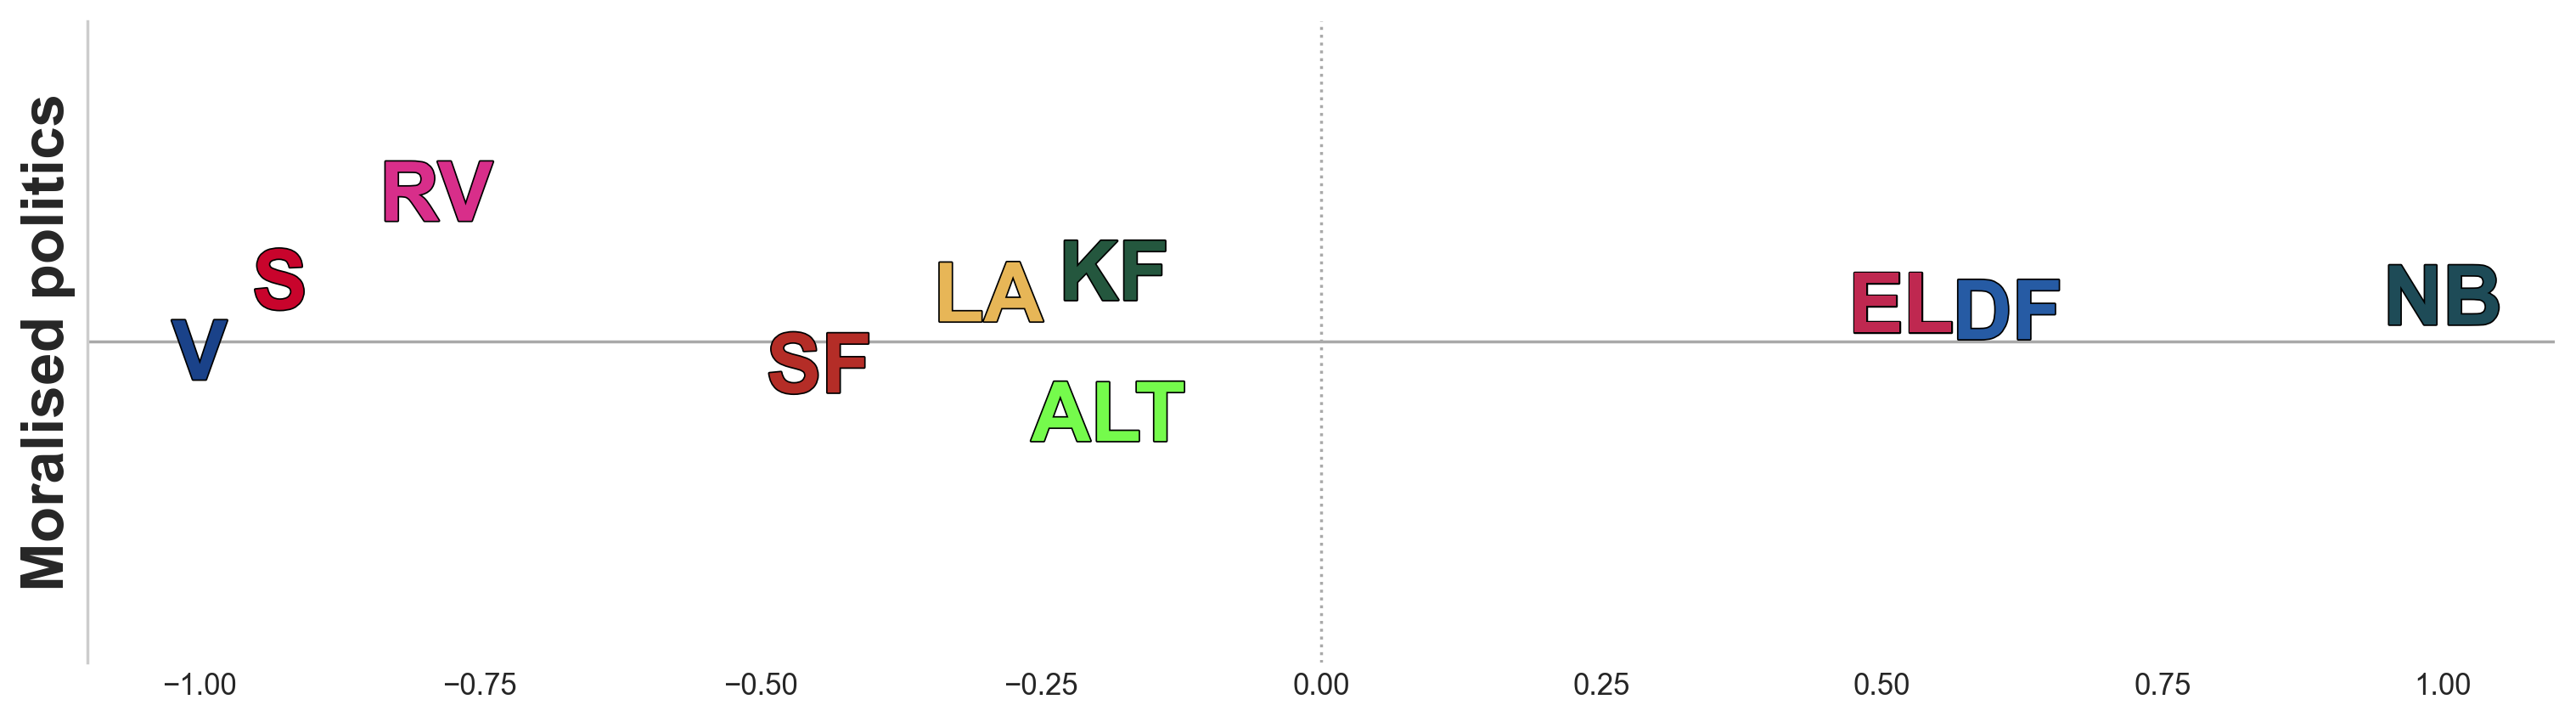

Moralised politics correlation: (0.9678583337380291, 4.491604151376423e-06)


In [4423]:
plt.style.use('seaborn-whitegrid')

test_metrics = ['PC', 'AP', 'MP']
comp_metrics = [PC_comp, AP_comp, MP_comp]
labels = ['People-centrism', 'Anti-pluralism', 'Moralised politics']

for test_metric, comp_metric, lab in zip(test_metrics, comp_metrics, labels):

    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    ax.set_ylabel(lab, size = 20, weight = 'bold')

    ax.scatter(df_plot[test_metric], np.zeros_like(df_plot[test_metric]), s=50, alpha=0.75, color='none')

    # # add party labels
    for i, txt in enumerate(df_plot['party']):
        ax.text(df_plot[test_metric][i], y_jitter[i], txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=1)])

    # # add party labels
    # for i, txt in enumerate(df_plot['party']):
    #     ax.text(df_plot[comp_metric][i], -.01, txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=.2, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=.5)])

    # for i, txt in enumerate(df_test['party']):
    #     ax.text(rescale(df_test['V4_scale'])[i], rescale(df_test['value'])[i], txt, ha='center', va='center', fontsize=12, color=df_test['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black', alpha=1)])

    # draw line segment between pos and eu_avg for each party
    # for i in range(len(df_plot)):
    #     ax.plot([df_plot[test_metric][i], df_plot[comp_metric][i]], [0.01, -0.01], color=df_plot['color'][i], alpha=.5, linewidth=1, linestyle='--')

    # add vline to plot
    ax.axvline(x=0, color='darkgrey', linestyle=':', linewidth=1)
    ax.axhline(y=0, color='darkgrey', linestyle='-', linewidth=1)

    for spine in list(ax.spines.values())[1:]:
        spine.set_visible(False)

    ax.set_yticks([])
    ax.grid(False)

    # set ylim
    ax.set_ylim(-0.02, 0.02)

    # Show the plot
    plt.show()

    print(f'{lab} correlation:', pearsonr(df_plot[test_metric], df_plot[comp_metric]))

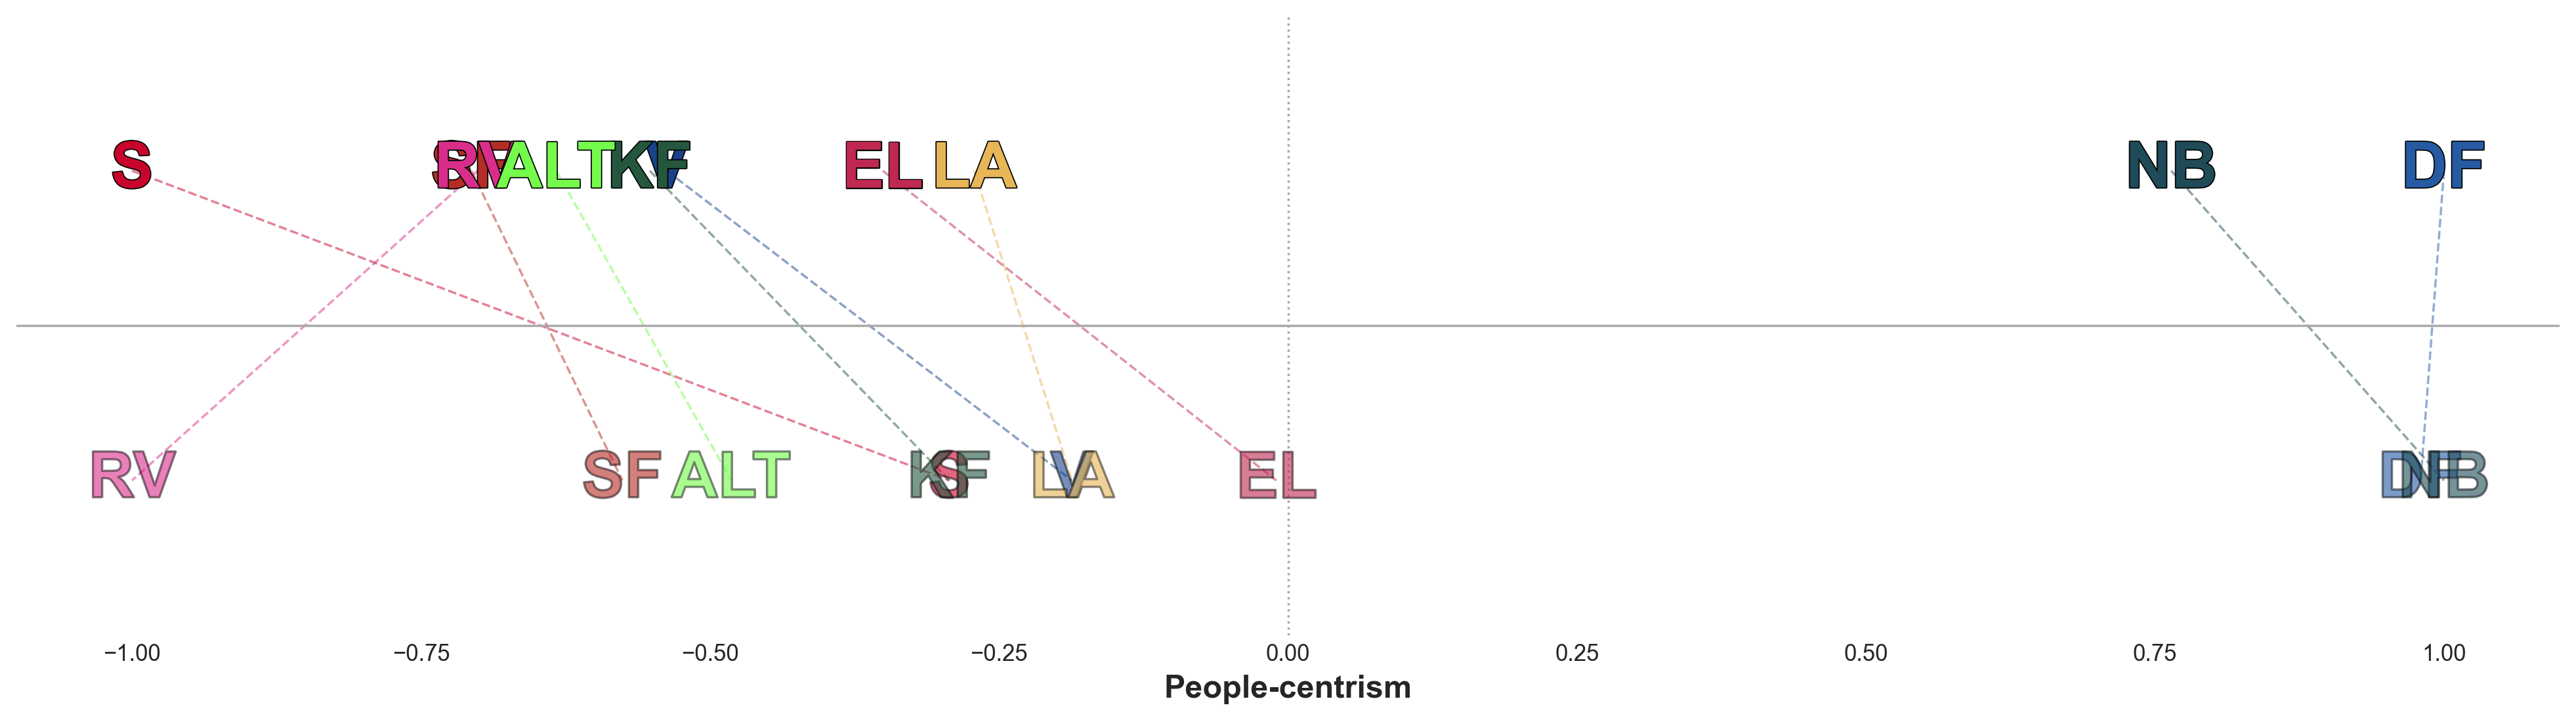

People-centrism correlation: (0.9177517985489356, 0.00018111807251381269)


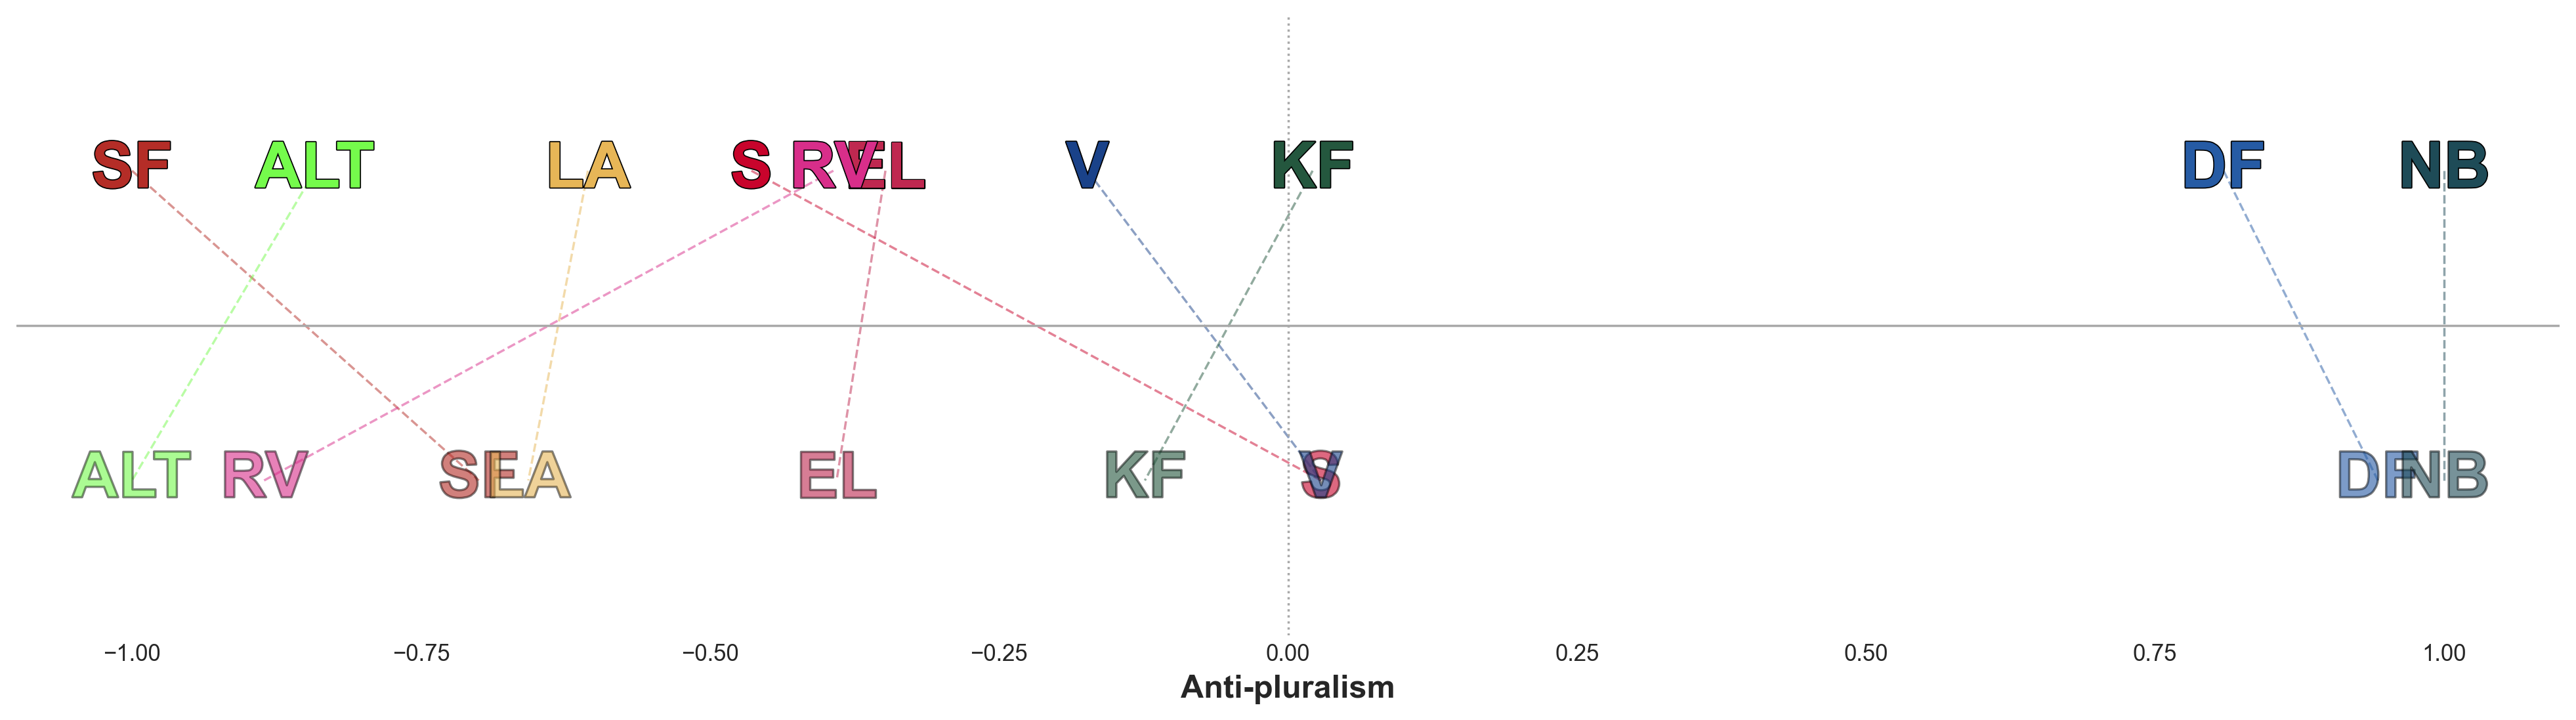

Anti-pluralism correlation: (0.862495177777719, 0.001320465829694413)


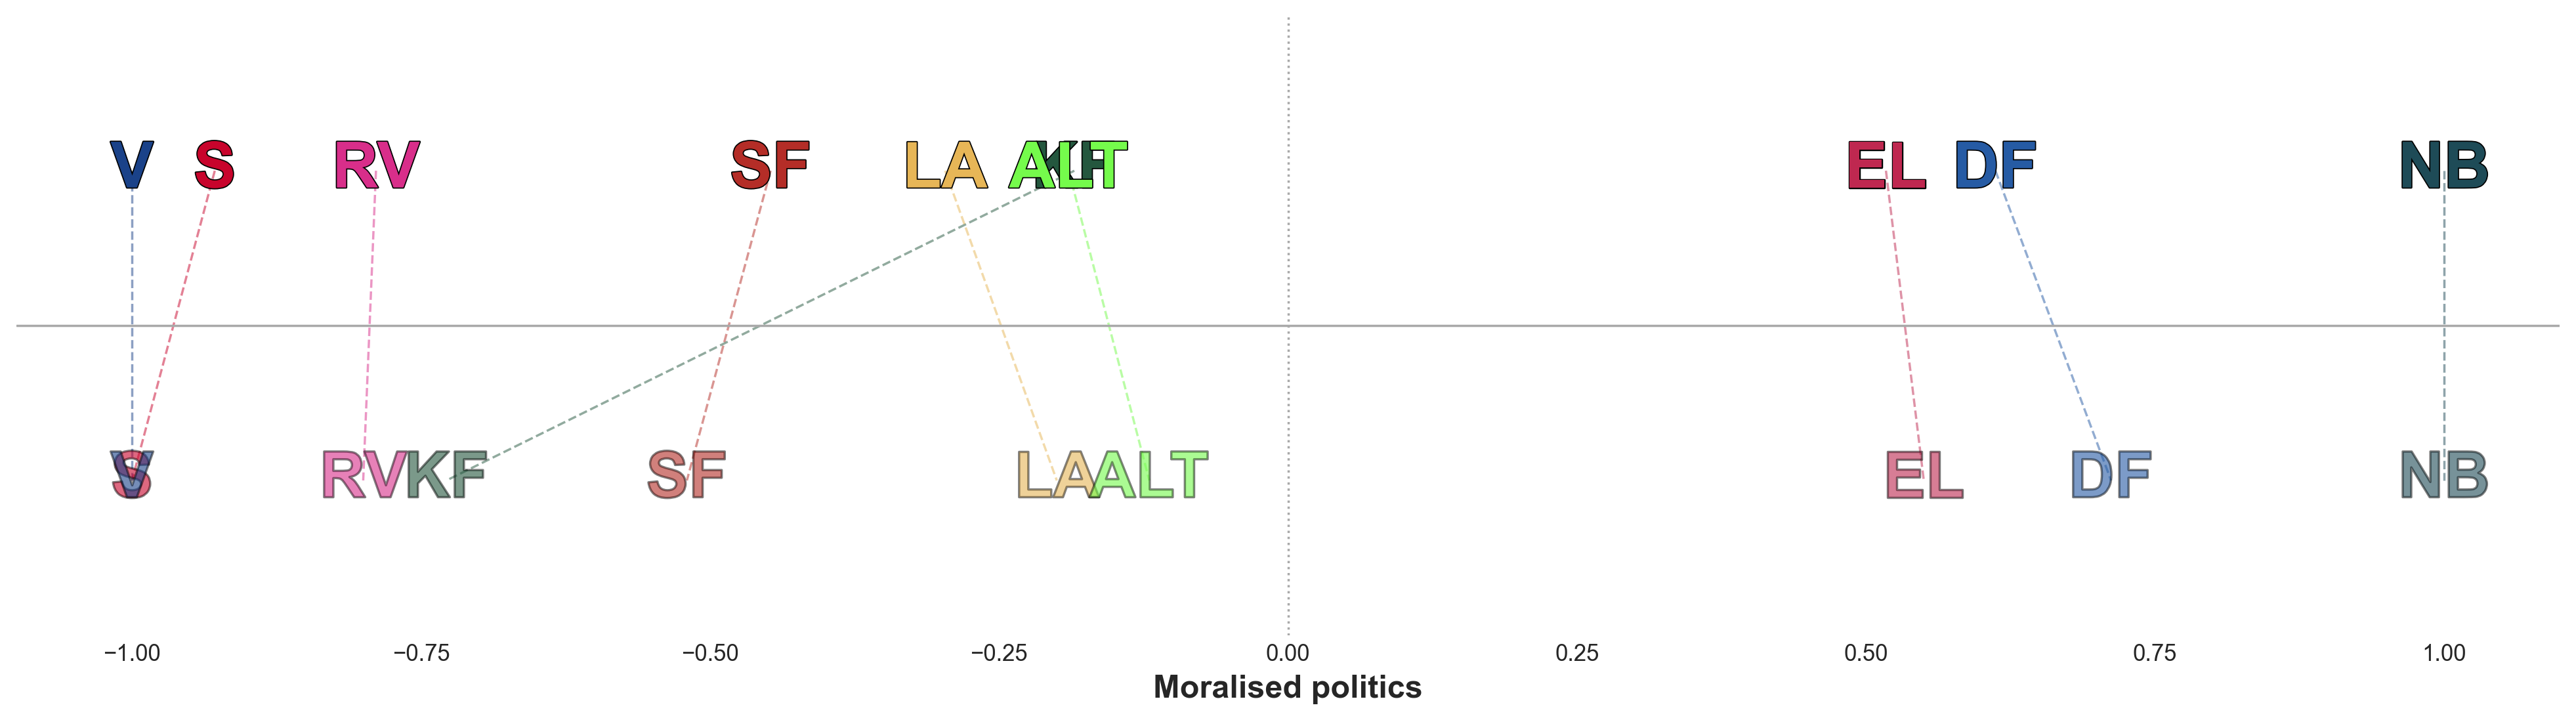

Moralised politics correlation: (0.7974230534203002, 0.005723551131387592)


In [4415]:
plt.style.use('seaborn-whitegrid')

test_metrics = ['PC', 'AP', 'MP']
comp_metrics = [PC_comp, AP_comp, MP_comp]
labels = ['People-centrism', 'Anti-pluralism', 'Moralised politics']

for test_metric, comp_metric, lab in zip(test_metrics, comp_metrics, labels):

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    ax.set_ylabel(lab, size = 20, weight = 'bold')

    ax.scatter(df_plot[test_metric], np.zeros_like(df_plot[test_metric]), s=50, alpha=0.75, color='none')
    ax.scatter(df_plot[comp_metric], np.zeros_like(df_plot[comp_metric]), s=50, alpha=0.75, color='none')

    # # add party labels
    for i, txt in enumerate(df_plot['party']):
        ax.text(df_plot[test_metric][i], .01, txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=1)])

    # # add party labels
    for i, txt in enumerate(df_plot['party']):
        ax.text(df_plot[comp_metric][i], -.01, txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=.2, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=.5)])

    # for i, txt in enumerate(df_test['party']):
    #     ax.text(rescale(df_test['V4_scale'])[i], rescale(df_test['value'])[i], txt, ha='center', va='center', fontsize=12, color=df_test['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black', alpha=1)])

    # draw line segment between pos and eu_avg for each party
    for i in range(len(df_plot)):
        ax.plot([df_plot[test_metric][i], df_plot[comp_metric][i]], [0.01, -0.01], color=df_plot['color'][i], alpha=.5, linewidth=1, linestyle='--')

    # add vline to plot
    ax.axvline(x=0, color='darkgrey', linestyle=':', linewidth=1)
    ax.axhline(y=0, color='darkgrey', linestyle='-', linewidth=1)

for spine in list(ax.spines.values())[1:]:
    spine.set_visible(False)

    ax.set_yticks([])
    ax.grid(False)

    # set ylim
    ax.set_ylim(-0.02, 0.02)

    # Show the plot
    plt.show()

    print(f'{lab} correlation:', pearsonr(df_plot[test_metric], df_plot[PC_comp]))

In [4370]:
# plot the correlation matrix
corr = df_plot.drop(columns=['rank']).corr()
corr.style.background_gradient(cmap='coolwarm')

,peoplecentrism,indivisble,manichean,populism,PC,AP,MP
peoplecentrism,1.000000,0.906721,0.796929,0.974502,0.917752,0.862495,0.797423
indivisble,0.906721,1.000000,0.525036,0.938028,0.787176,0.920730,0.564355
manichean,0.796929,0.525036,1.000000,0.764684,0.841731,0.610737,0.967858
populism,0.974502,0.938028,0.764684,1.000000,0.876918,0.878689,0.787778
PC,0.917752,0.787176,0.841731,0.876918,1.000000,0.860455,0.824487
AP,0.862495,0.920730,0.610737,0.878689,0.860455,1.000000,0.664693
MP,0.797423,0.564355,0.967858,0.787778,0.824487,0.664693,1.000000


## Attempt at PCA projection of 3D subspace